In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

import tf_lab.autopredictors.scripts.virt_scan_data as vscan

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, points_extension, \
                                                 shape_net_core_synth_id_to_category

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch,\
                                           plot_3d_point_cloud_paper

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion, save_reconstructions, \
                                           save_pc_prediction_stats, \
                                           paper_pc_completion_experiment_id_best_epoch
                                           
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud, Mesh
from geo_tool.solids import mesh_cleaning as cleaning

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
GPU = 3
loss = 'chamfer'
incomplete_n_samples = 2048
complete_n_samples = 4096
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/paper_vanilla_vscan')

In [4]:
class_type = 'all_classes'
# class_type = 'chair'

In [5]:
experiment_id, best_epoch = paper_pc_completion_experiment_id_best_epoch(class_type, loss)
experiment_name = str(experiment_id) + '_' + class_type + '_' + str(incomplete_n_samples) + '_' \
                  + str(complete_n_samples) + 'pts_' + loss
train_dir = osp.join(train_dir, experiment_name)

In [6]:
conf = Conf.load(osp.join(train_dir, 'configuration'))
conf.consistent_io = None
conf.encoder_args = {'dropout_prob': 1.0}
print conf

              allow_gpu_growth: False
                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'non_linearity': <function relu at 0x7fb22a0e48c0>, 'layer_sizes': [1024, 12288]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {'dropout_prob': 1.0}
               experiment_name: 10_all_classes_2048_4096pts_chamfer
                 gauss_augment: None
                  is_denoising: True
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [4096, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 1
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/mo

In [7]:
reset_tf_graph()
set_visible_GPUs([GPU])
ae = PointNetAutoEncoder(experiment_name, conf)
ae.restore_model(train_dir, best_epoch)

In [8]:
top_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Charles_Real_Scans/objects/'
object_list = osp.join(top_dir, 'objectlist.txt')
with open(object_list, 'r') as fin:
    object_list = fin.readlines()

object_file_list = [osp.join(top_dir, ob.rstrip()) for ob in object_list]
object_names = [osp.basename(ob)[:-len('.obj')] for ob in object_file_list]
pc_file_list = [fname[:-len('.obj')] + '_2048_samples_pts.txt' for fname in object_file_list]

In [9]:
chair_rotate_degrees = [-45, -150, -135, -115, -110, 0, -25, -10, 90, -30, -130, -45, -135, 90, 90, 60, 0]
obj_list = ['chair_scan_0001', 'chair_scan_0010', 'chair_scan_0016', 'chair_scan_0007', \
            'chair_scan_0011', 'chair_scan_0006', 'chair_scan_0017', 'chair_scan_0012', \
            'chair_scan_0008', 'chair_scan_0003', 'chair_scan_0005', 'chair_scan_0014', \
            'chair_scan_0002', 'chair_scan_0009', 'chair_scan_0013', 'chair_scan_0015', \
            'chair_scan_0004']

obj2degree = {}
for idx, deg in enumerate(chair_rotate_degrees):
    obj2degree[obj_list[idx]] = deg

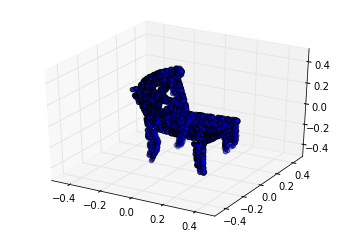

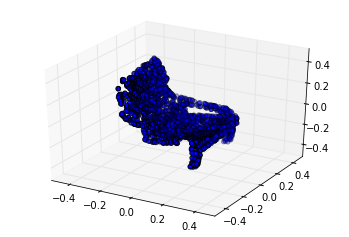

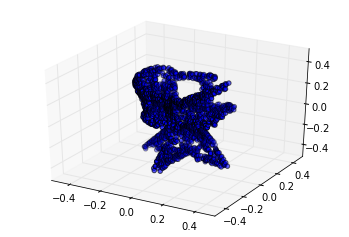

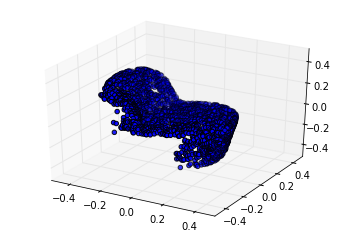

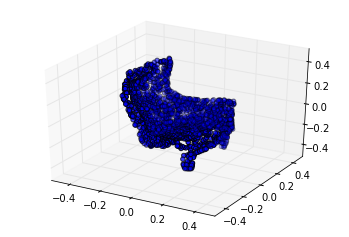

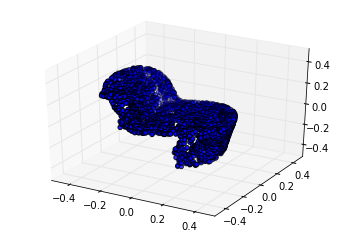

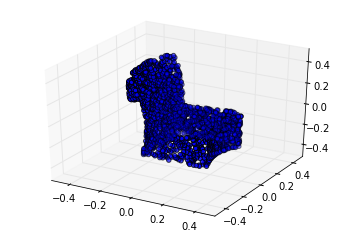

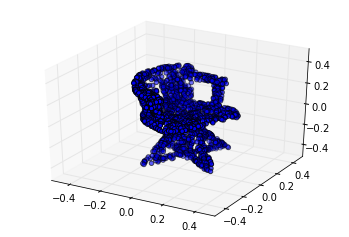

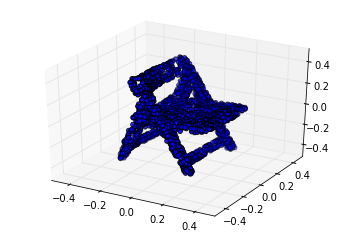

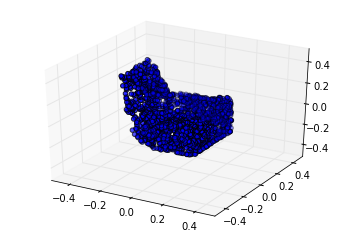

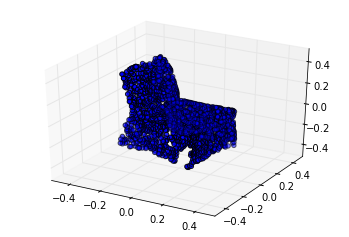

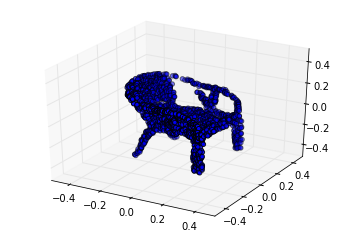

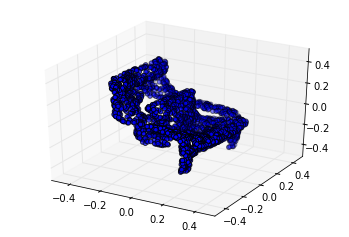

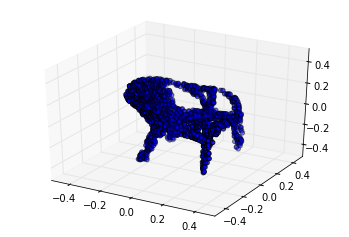

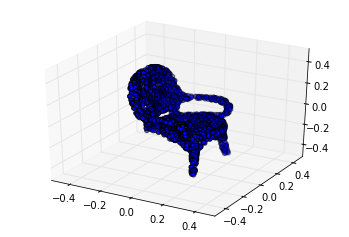

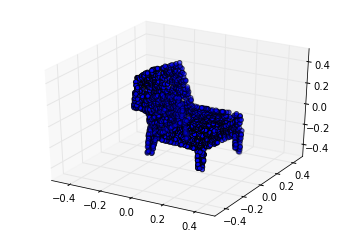

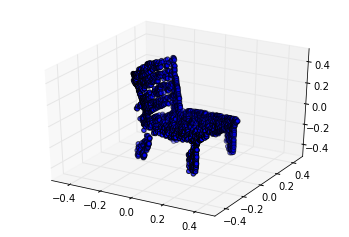

In [22]:
len(obj2degree)
feed = np.zeros((len(obj2degree), incomplete_n_samples, 3))
k = 0
for pc_file, ob_name in zip(pc_file_list, object_names) :
    if ob_name in obj2degree:
        pc = Point_Cloud(points=np.loadtxt(pc_file)).permute_points([2, 0, 1])
        pc.rotate_z_axis_by_degrees(obj2degree[ob_name])        
        pc.plot(in_u_sphere=True);    
        feed[k] = pc.points
        k += 1

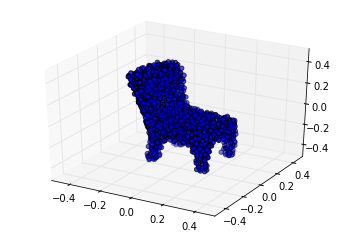

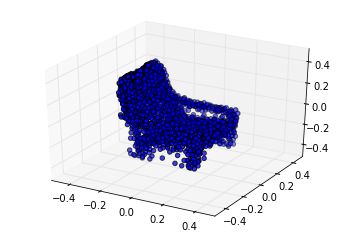

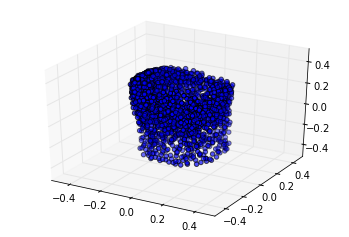

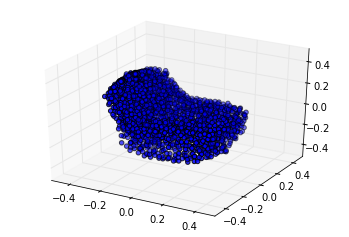

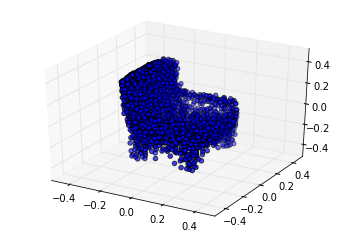

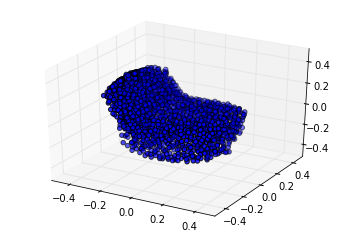

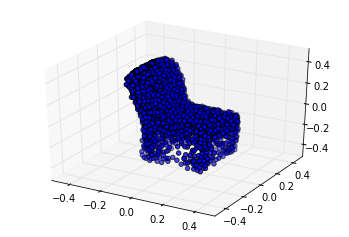

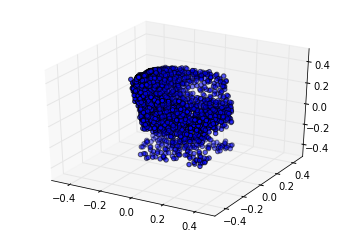

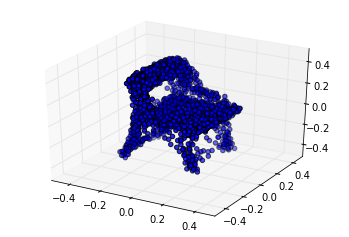

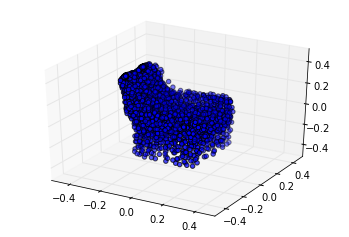

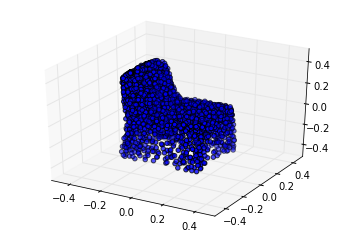

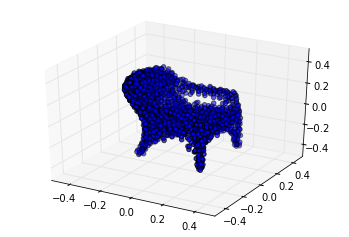

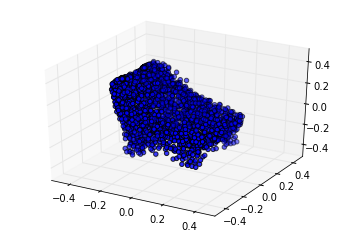

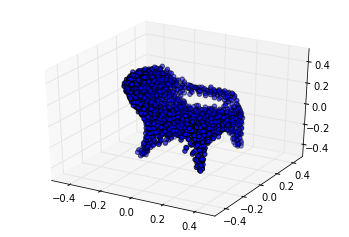

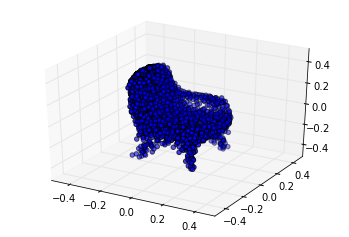

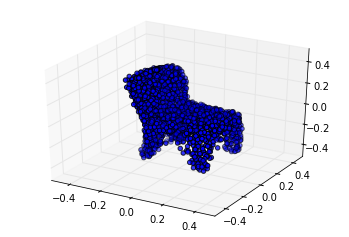

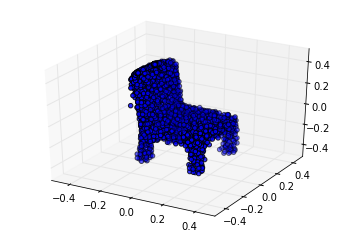

In [27]:

res = ae.reconstruct(feed, compute_loss=False)[0]
for pc in res:
    Point_Cloud(pc.reshape(4096, 3)).plot(in_u_sphere=True);
    
    
    


[0 0 0 ..., 3 3 3]


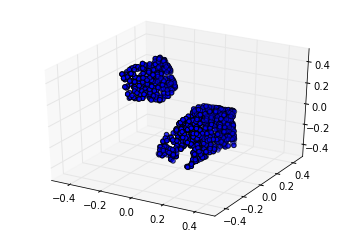

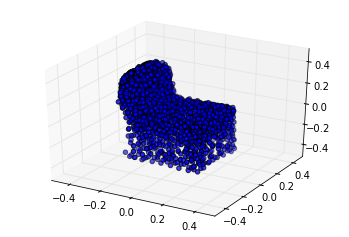

In [41]:
# # feed = pc.points
# # pc_inc_2, _ = Point_Cloud(points=pc.points).sample(100)
# # pc_inc_2, _ = pc_inc_2.sample(2048)
# # pc_inc_2.plot()

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(pc.points)
print kmeans.labels_

check = [0,1,2]
ckeck = np.array([i in check for i in kmeans.labels_], dtype=np.bool)

pc_inc_2, _ = Point_Cloud(points=pc.points[ckeck,:]).sample(2048)
pc_inc_2.plot(in_u_sphere=True)



feed = pc_inc_2.points
feed = feed.reshape(1, 2048, 3)
res = ae.reconstruct(feed, compute_loss=False)[0]
Point_Cloud(res.reshape(4096, 3)).plot(in_u_sphere=True);